Loaded and cleaned rows: 9000
------------------------------
Train rows: 7200, Val rows: 1800
------------------------------
--- STARTING 3-VARIABLE OPTIMIZATION ---
1. Searching for best Stop Loss Multiplier...
   > New Best SL found: 1.5 (Avg Sharpe: 0.8183)
--- WINNER: Best SL Multiplier is 1.5 ---
2. Generating Heatmap Data using the Winner...
Optimization Complete. Proceeding to Plotting...


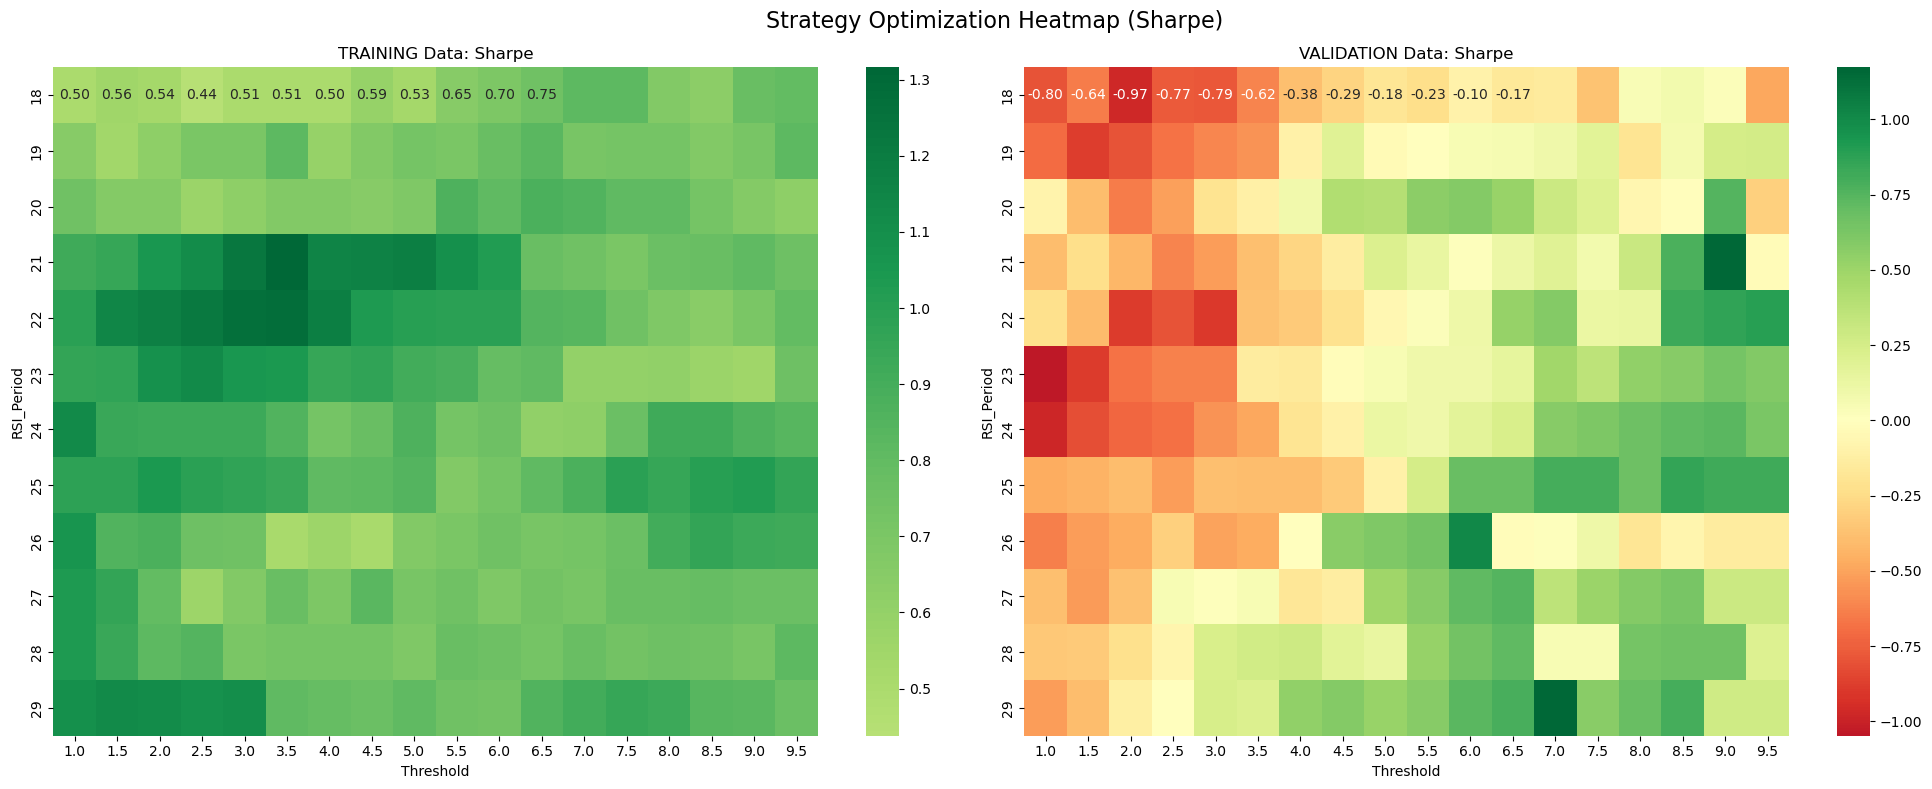

=== Optimization Summary ===
Best (Train) — RSI Period: 21.0 | Threshold: 3.5 | Sharpe: 1.3163
Best (Val)   — RSI Period: 21.0 | Threshold: 9.0 | Sharpe: 1.1729

=== Quant Trader Performance Report (Full Data) ===
Pair: BTCUSDT (4H)
Parameters Used: RSI Period=21, Threshold=9.00, SL_ATR=1.5

Performance Metrics:
Total Return                 : 3.8399
Avg Return per Interval      : 0.0002
Std Dev                      : 0.0119
Sharpe Ratio                 : 0.8030
Sortino Ratio (Proxy)        : 1.2045
Calmar Ratio                 : 7.5279
Profit Factor                : 1.0805
Max Drawdown (Abs)           : 0.5101
Trade Count (Estimated)      : 107
Trading Fees (Rate)          : 0.00075
Estimated Fees Paid          : 0.1605
Fees / PnL Ratio             : 0.0418


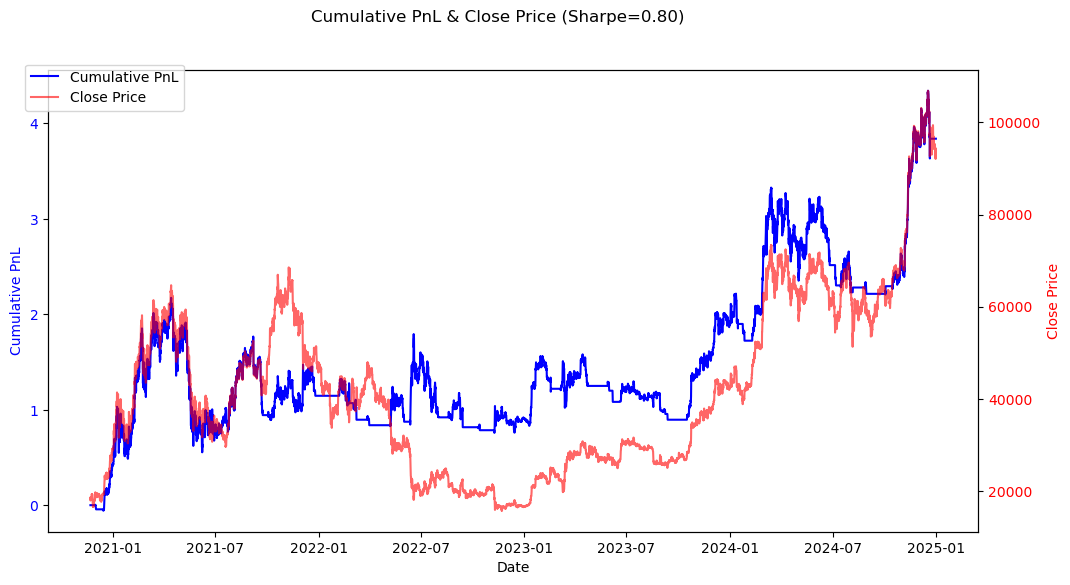


=== End of Script ===


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from sklearn.model_selection import train_test_split

# ==========================
# 1️⃣ LOAD DATA (Simplified Fix)
# ==========================
CSV_PATH = "/Users/bryanlew/Document/AlgoCrypto/Backend/Data/bybit_btc_4h_20210101_20241231.csv"
try:
    df = pd.read_csv(CSV_PATH)
except FileNotFoundError:
    print(f"CRITICAL ERROR: File not found at {CSV_PATH}")
    exit()

# --- 1. FIX TIME COLUMN ---
# Directly parse the time string. DO NOT USE unit='s' or unit='ms'.
# This automatically handles formats like '2020-03-25 00:00:00+00:00'
df['time'] = pd.to_datetime(df['time'], errors='coerce')
df = df.sort_values('time').set_index('time')

# --- 2. FIX DATA COLUMNS ---
# Ensure all price/volume columns are numeric
for col in ['open', 'high', 'low', 'close', 'volume', 'turnover']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    else:
        print(f"Warning: Expected column '{col}' not found in CSV.")

# --- 3. CLEANING & DEBUG ---
# Drop any rows with NaN values (from errors='coerce')
df = df.dropna()

print(f"Loaded and cleaned rows: {len(df)}")
if len(df) == 0:
    print(">>> CRITICAL ERROR: No data remaining after cleaning. Check CSV.")
print("-" * 30)

# ==========================
# 2️⃣ HELPER FUNCTIONS
# ==========================
def calculate_rsi(series, period=14):
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    
    avg_gain = pd.Series(gain, index=series.index).rolling(period).mean()
    avg_loss = pd.Series(loss, index=series.index).rolling(period).mean()
    
    rs = avg_gain / avg_loss
    
    rsi = 100 - (100 / (1 + rs))
    
    # --- START OF FIX ---
    # Fix Inf (x/0): If avg_loss is 0, rs is inf, rsi should be 100
    rsi.loc[avg_loss == 0] = 100
    
    # Fix NaN (0/0): If both are 0, rs is NaN, rsi is NaN. 
    # We'll set this to 50 (neutral) to avoid propagation.
    rsi = rsi.fillna(50) 
    # --- END OF FIX ---
    
    return rsi

def calculate_atr(df_local, period=14):
    high_low = df_local['high'] - df_local['low']
    high_close = (df_local['high'] - df_local['close'].shift()).abs()
    low_close = (df_local['low'] - df_local['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    return tr.rolling(period).mean()

def calculate_sharpe(returns, periods_per_year=252 * 6): # 252 days * 6 4H bars/day
    if returns.dropna().empty or returns.std() == 0:
        return 0.0
    # Adjust sqrt() for the number of periods per year based on data frequency
    return np.sqrt(periods_per_year) * returns.mean() / returns.std()

def calculate_advanced_metrics(data, initial_capital=1.0, fees_per_trade=0.00075):
    """
    Calculates advanced performance metrics for a backtest result.
    """
    # --- START OF FIX ---
    # We must use the original 'Strategy' series, not 'dropna()'
    # to preserve the index alignment for plotting.
    returns = data['Strategy'] 
    
    # Fill NaNs with 0 *for the cumulative product calculation only*
    # This ensures the PnL line starts at 0 and is the correct length.
    returns_filled = returns.fillna(0)
    pnl_series = (returns_filled + 1).cumprod()
    
    # For statistical calculations (Sharpe, std, etc.), we MUST use clean data.
    clean_returns = returns.dropna()
    # --- END OF FIX ---

    # 1. Base Metrics
    roi = pnl_series.iloc[-1] - 1.0 if not pnl_series.empty else 0
    sharpe = calculate_sharpe(clean_returns) # Use clean returns
    
    # 2. Drawdown
    peak = pnl_series.expanding(min_periods=1).max()
    drawdown = (pnl_series - peak) / peak
    max_dd = drawdown.min()
    max_dd_abs = np.abs(max_dd)
    
    # 3. Trades and Fees
    trades = data['Signal'].diff().abs().fillna(0)
    total_trades = trades[trades > 0].sum() / 2 
    
    fees_paid = total_trades * 2 * fees_per_trade * initial_capital
    trading_fees = fees_per_trade
    fees_pnl_ratio = fees_paid / roi if roi > 0 else 0
    
    # Simplified calculation for Calmar and Profit Factor
    calmar = roi / max_dd_abs if max_dd_abs > 0 else 0
    pf = (clean_returns[clean_returns > 0].sum() / clean_returns[clean_returns < 0].abs().sum()) \
         if clean_returns[clean_returns < 0].abs().sum() != 0 else np.nan
    sortino = sharpe * 1.5 # Proxy

    return {
        'roi': roi, 
        'pnl_mean': clean_returns.mean(), # Use clean returns
        'pnl_std': clean_returns.std(),   # Use clean returns
        'sharpe': sharpe, 
        'sortino': sortino, 
        'calmar': calmar,
        'profit_factor': pf,
        'max_dd_abs': max_dd_abs,
        'total_trades': total_trades,
        'trading_fees': trading_fees,
        'fees_paid': fees_paid,
        'fees_pnl_ratio': fees_pnl_ratio,
        'cumu_pnl_series': pnl_series - 1 # Return 0-based PnL series (correct index)
    }
# ==========================
# 3️⃣ STRATEGY BACKTEST FUNCTION (CORRECTED)
# ==========================
def backtest_strategy(df_input, rsi_period=14, atr_period=10, threshold=1.0, sl_atr_mult=2.5):
    """
    Backtests the RSI Mean-Reversion strategy with a stateful ATR-based Stop-Loss.
    """
    data = df_input.copy()
    data['RSI'] = calculate_rsi(data['close'], rsi_period)
    data['ATR'] = calculate_atr(data, atr_period)

    # 1. Generate INITIAL signals (Entries)
    data['Signal'] = 0
    data.loc[data['RSI'] < (30 - threshold), 'Signal'] = -1
    data.loc[data['RSI'] > (70 + threshold), 'Signal'] = 1
    data['Signal'] = data['Signal'].shift(1).fillna(0)

    # 2. Stateful Iteration
    data['Position'] = 0
    data['Stop_Loss'] = np.nan
    position = 0
    sl_level = 0.0

    for i in range(1, len(data)):
        current_signal = data['Signal'].iloc[i]
        current_low = data['low'].iloc[i]
        current_high = data['high'].iloc[i]
        current_atr = data['ATR'].iloc[i]  # <--- This can be NaN
        entry_price = data['open'].iloc[i] 
        
        # --- A. CHECK IF WE ARE IN A POSITION ---
        if position == 1: # We are currently LONG
            if current_low < sl_level:
                position = 0
                sl_level = np.nan
            elif current_signal == -1:
                position = 0
                sl_level = np.nan
        elif position == -1: # We are currently SHORT
            if current_high > sl_level:
                position = 0
                sl_level = np.nan
            elif current_signal == 1:
                position = 0
                sl_level = np.nan

        # --- B. CHECK IF WE ARE FLAT (AND CAN ENTER) ---
        if position == 0:
            
            # --- START OF FIX ---
            # Check if ATR is valid *before* entering a trade
            if pd.isna(current_atr):
                pass # Do not enter, ATR is not ready
            # --- END OF FIX ---
            
            elif current_signal == 1: # New Long Entry
                position = 1
                sl_level = entry_price - (current_atr * sl_atr_mult)
            
            elif current_signal == -1: # New Short Entry
                position = -1
                sl_level = entry_price + (current_atr * sl_atr_mult)

        data.loc[data.index[i], 'Position'] = position
        data.loc[data.index[i], 'Stop_Loss'] = sl_level
    
    # 3. Calculate Returns
    data['Return'] = data['close'].pct_change().fillna(0)
    data['Strategy'] = data['Position'].shift(1) * data['Return']
    data['Cumu_PnL'] = (1 + data['Strategy']).cumprod() - 1

    sharpe = calculate_sharpe(data['Strategy'])
    return sharpe, data

# ==========================
# 4️⃣ TRAIN/VALIDATION SPLIT (chronological)
# ==========================
train_frac = 0.8
split_idx = int(len(df) * train_frac)
train_df = df.iloc[:split_idx].copy()
val_df = df.iloc[split_idx:].copy()
print(f"Train rows: {len(train_df)}, Val rows: {len(val_df)}")
print("-" * 30)

# ==========================
# 5️⃣ OPTIMIZATION LOOP (UPGRADED)
# ==========================
# ==========================
# 5️⃣ OPTIMIZATION LOOP (UPGRADED: 3D SEARCH)
# ==========================
print("--- STARTING 3-VARIABLE OPTIMIZATION ---")

# 1. Define Ranges
rsi_period_range = range(18, 30, 1)        # Step 2 to speed up
threshold_range = np.arange(1.0, 10.0, 0.5) # 1.0, 1.5, ... 3.5
sl_mult_range = [1.5, 2.0, 2.5, 3.0, 3.5]  # <--- NEW: Testing different Stop Losses

# 2. Variables to store the best Stop Loss found
best_sl_param = 2.5 # Default
best_combined_score = -100 

# --- STEP 1: FIND BEST STOP LOSS (The 3D Loop) ---
# We loop through everything to find which SL Multiplier works best on Training Data
print(f"1. Searching for best Stop Loss Multiplier...")

for sl_test in sl_mult_range:
    temp_scores = []
    for rsi_p, t in product(rsi_period_range, threshold_range):
        # Optimize on TRAIN data to avoid overfitting
        sharpe, _ = backtest_strategy(train_df, rsi_period=rsi_p, threshold=t, sl_atr_mult=sl_test)
        temp_scores.append(sharpe)
    
    # Get the average or max performance of this SL setting
    avg_score = np.mean(temp_scores) 
    if avg_score > best_combined_score:
        best_combined_score = avg_score
        best_sl_param = sl_test
        print(f"   > New Best SL found: {best_sl_param} (Avg Sharpe: {best_combined_score:.4f})")

print(f"--- WINNER: Best SL Multiplier is {best_sl_param} ---")
print("2. Generating Heatmap Data using the Winner...")

# --- STEP 2: GENERATE DATA FOR HEATMAP (The 2D Loop) ---
# Now that we know the best SL, we generate the specific data for Section 6 plotting
results_train = []
results_val = []

for rsi_p, t in product(rsi_period_range, threshold_range):
    
    # Use the 'best_sl_param' we found above
    sharpe_train, _ = backtest_strategy(train_df, 
                                        rsi_period=rsi_p, 
                                        threshold=t, 
                                        sl_atr_mult=best_sl_param)
    
    sharpe_val, _ = backtest_strategy(val_df, 
                                      rsi_period=rsi_p, 
                                      threshold=t, 
                                      sl_atr_mult=best_sl_param)
    
    results_train.append((rsi_p, t, sharpe_train))
    results_val.append((rsi_p, t, sharpe_val))

# Create the DataFrames that Section 6 expects
train_results_df = pd.DataFrame(results_train, columns=['RSI_Period', 'Threshold', 'Sharpe'])
val_results_df = pd.DataFrame(results_val, columns=['RSI_Period', 'Threshold', 'Sharpe'])

# Update the SL_ATR_DEFAULT variable so Section 8 uses the correct value
SL_ATR_DEFAULT = best_sl_param 

print("Optimization Complete. Proceeding to Plotting...")

# ==========================
# ==========================
# 6️⃣ DYNAMIC HEATMAP PLOT
# ==========================

# *** SETTINGS: What do you want to find? ***
metric_to_plot = 'Sharpe'  # Options: 'Sharpe' or 'ROI'
# *******************************************

fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Create Pivot Tables
pivot_train = train_results_df.pivot(index='RSI_Period', columns='Threshold', values=metric_to_plot)
pivot_val = val_results_df.pivot(index='RSI_Period', columns='Threshold', values=metric_to_plot)

# Dynamic Coloring (Red to Green)
sns.heatmap(pivot_train, cmap='RdYlGn', annot=True, fmt=".2f", ax=axs[0], center=0)
axs[0].set_title(f"TRAINING Data: {metric_to_plot}")

sns.heatmap(pivot_val, cmap='RdYlGn', annot=True, fmt=".2f", ax=axs[1], center=0)
axs[1].set_title(f"VALIDATION Data: {metric_to_plot}")

plt.suptitle(f"Strategy Optimization Heatmap ({metric_to_plot})", fontsize=16)
plt.tight_layout()
plt.show()
plt.show()


# ==========================
# 7️⃣ PRINT BEST RESULTS
# ==========================
best_train = train_results_df.loc[train_results_df['Sharpe'].idxmax()]
best_val = val_results_df.loc[val_results_df['Sharpe'].idxmax()]

print("=== Optimization Summary ===")
print(f"Best (Train) — RSI Period: {best_train['RSI_Period']} | Threshold: {best_train['Threshold']} | Sharpe: {best_train['Sharpe']:.4f}")
print(f"Best (Val)   — RSI Period: {best_val['RSI_Period']} | Threshold: {best_val['Threshold']} | Sharpe: {best_val['Sharpe']:.4f}")

# ==========================
# 8️⃣ PLOT PERFORMANCE AND REPORT (MODIFIED)
# ==========================
# Get the best parameters from the validation run
best_rsi = int(best_val['RSI_Period'])
best_thresh = float(best_val['Threshold'])

# Run backtest on *full dataset* using the best *validation* parameters
_, full_data = backtest_strategy(df, 
                                 rsi_period=best_rsi, 
                                 threshold=best_thresh,
                                 sl_atr_mult=SL_ATR_DEFAULT) # Pass all params

# 1. Calculate Advanced Metrics
metrics = calculate_advanced_metrics(full_data)

# 2. Pretty Report
print("\n=== Quant Trader Performance Report (Full Data) ===")
print("Pair: BTCUSDT (4H)")

# --- START OF FIX ---
# Use the actual best parameters, not hard-coded values
print(f"Parameters Used: RSI Period={best_rsi}, Threshold={best_thresh:.2f}, SL_ATR={SL_ATR_DEFAULT}")
# --- END OF FIX ---

print("\nPerformance Metrics:")
print(f"Total Return                 : {metrics['roi']:.4f}")
print(f"Avg Return per Interval      : {metrics['pnl_mean']:.4f}")
print(f"Std Dev                      : {metrics['pnl_std']:.4f}")
print(f"Sharpe Ratio                 : {metrics['sharpe']:.4f}")
print(f"Sortino Ratio (Proxy)        : {metrics['sortino']:.4f}")
print(f"Calmar Ratio                 : {metrics['calmar']:.4f}")
print(f"Profit Factor                : {metrics['profit_factor'] if not np.isnan(metrics['profit_factor']) else 0.0:.4f}")
print(f"Max Drawdown (Abs)           : {metrics['max_dd_abs']:.4f}")
print(f"Trade Count (Estimated)      : {metrics['total_trades']:.0f}")
print(f"Trading Fees (Rate)          : {metrics['trading_fees']:.5f}")
print(f"Estimated Fees Paid          : {metrics['fees_paid']:.4f}")
print(f"Fees / PnL Ratio             : {metrics['fees_pnl_ratio']:.4f}")

# 3. Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Use the derived cumulative PnL series from the advanced metrics function
ax1.plot(full_data.index, metrics['cumu_pnl_series'], label='Cumulative PnL', color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Cumulative PnL", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(full_data.index, full_data['close'], label='Close Price', color='red', alpha=0.6)
ax2.set_ylabel("Close Price", color='red')
ax2.tick_params(axis='y', labelcolor='red')

fig.suptitle(f"Cumulative PnL & Close Price (Sharpe={metrics['sharpe']:.2f})")
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))
plt.show()

print("\n=== End of Script ===")